In [107]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split,ShuffleSplit
from sklearn.linear_model import  LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb
import matplotlib.pyplot as plt

In [108]:
data=pd.read_csv('Bengaluru_House_Data.csv')
print(data.head())
print(data.shape)

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
(13320, 9)


In [109]:
data.groupby('area_type')['area_type'].count()

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [110]:
data.drop(['availability','balcony', 'area_type','society'],axis=1,inplace=True)
data.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [111]:
print(data.shape)
data.isnull().sum()

(13320, 5)


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

as we can see we have 0.6 of the data is not available, which is not a lot so we precede the cleaning orpartion by removing those 
rows

In [112]:
data.dropna(inplace=True)
data.shape

(13246, 5)

In [113]:
data['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [114]:
data['Bedrooms']=data['size'].apply(lambda x: float(x.split(' ')[0]))
data.drop(['size'],axis=1,inplace=True)
data.head()
print(data.shape)

(13246, 5)


In [115]:
print(data['Bedrooms'].value_counts())
print(data.total_sqft.unique())

2.0     5527
3.0     4832
4.0     1395
1.0      649
5.0      353
6.0      221
7.0      100
8.0       89
9.0       54
10.0      14
11.0       4
27.0       1
19.0       1
16.0       1
43.0       1
14.0       1
12.0       1
13.0       1
18.0       1
Name: Bedrooms, dtype: int64
['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']


In [116]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True        

In [117]:
data[~data['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,price,Bedrooms
30,Yelahanka,2100 - 2850,4.0,186.000,4.0
122,Hebbal,3067 - 8156,4.0,477.000,4.0
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2.0
165,Sarjapur,1145 - 1340,2.0,43.490,2.0
188,KR Puram,1015 - 1540,2.0,56.800,2.0
410,Kengeri,34.46Sq. Meter,1.0,18.500,1.0
549,Hennur Road,1195 - 1440,2.0,63.770,2.0
648,Arekere,4125Perch,9.0,265.000,9.0
661,Yelahanka,1120 - 1145,2.0,48.130,2.0
672,Bettahalsoor,3090 - 5002,4.0,445.000,4.0


In [118]:
def convert_total_sqft_to_float(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None               

In [119]:
data.total_sqft=data.total_sqft.apply(convert_total_sqft_to_float)
data.dropna(inplace=True)
data.shape
data.head()

,location,total_sqft,bath,price,Bedrooms
0,Electronic City Phase II,1056.0,2.0,39.07,2.0
1,Chikka Tirupathi,2600.0,5.0,120.00,4.0
2,Uttarahalli,1440.0,2.0,62.00,3.0
3,Lingadheeranahalli,1521.0,3.0,95.00,3.0
4,Kothanur,1200.0,2.0,51.00,2.0


Feature Engineering
Add new feature called price per square feet

In [120]:
data['price_per_sqft']=data['price']*100000/data['total_sqft']
data.head()

,location,total_sqft,bath,price,Bedrooms,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,1200.0,2.0,51.00,2.0,4250.000000


In [121]:
data.location=data.location.apply(lambda x: x.strip())
data_location=data.groupby('location')['location'].agg('count').sort_values(ascending=False)
print(data_location)

location
Whitefield               533
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           264
Thanisandra              235
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64


In [122]:
data_location_less_than_10=data_location[data_location<=10]
len(data_location_less_than_10.index)

1047

In [123]:
data.location=data.location.apply(lambda x:'other' if x in data_location_less_than_10.index else x )
len(data.location.unique())

241

In [124]:
data=data[~(data.total_sqft/data.Bedrooms<300)]
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
data = remove_pps_outliers(data)
print(data.shape)

(10242, 6)


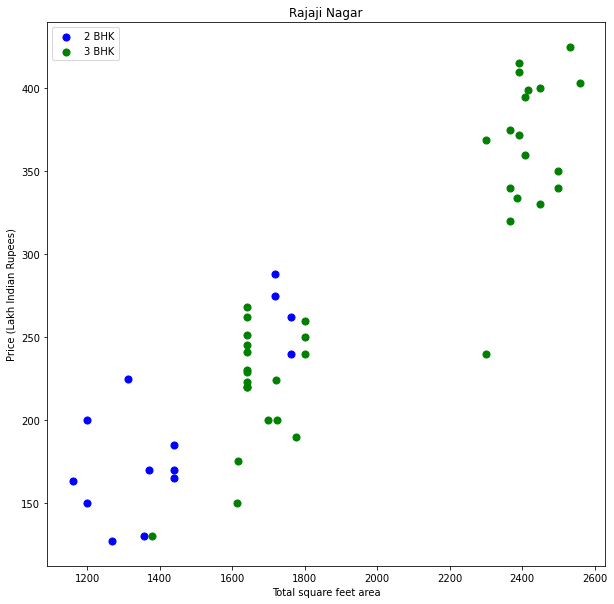

In [125]:
def desturbution_per_location(data,location):
    plt.figure(figsize=(10,10))
    data_location_2=data[(data.location==location)&(data.Bedrooms==2)]
    data_location_3=data[(data.location==location)&(data.Bedrooms==3)]
    plt.scatter( data_location_2['total_sqft'],data_location_2['price'],color='blue',label='2 BHK', s=50)    
    plt.scatter( data_location_3['total_sqft'],data_location_3['price'], color='green',label='3 BHK', s=50)
    plt.xlabel('Total square feet area')
    plt.ylabel('Price (Lakh Indian Rupees)')
    plt.title(location)
    plt.legend(loc='best')
desturbution_per_location(data,"Rajaji Nagar")   

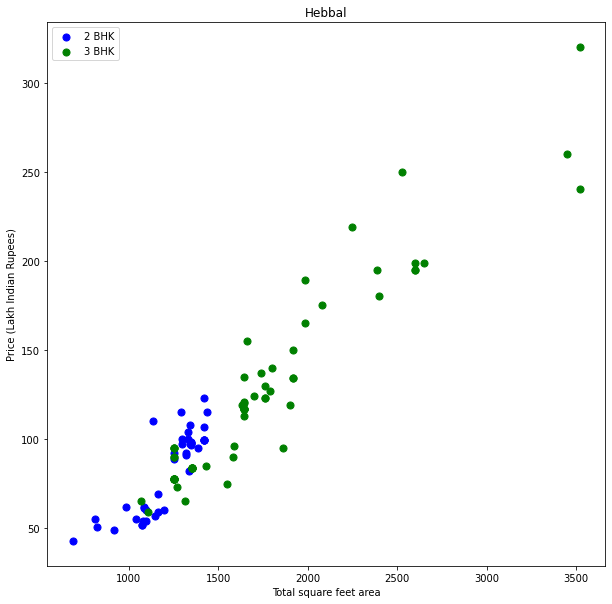

In [126]:
desturbution_per_location(data,"Hebbal")

In [127]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }    
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            stats = bhk_stats.get(bhk-1)
            if   stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
                #print(exclude_indices)
    return df.drop(exclude_indices,axis='index')
data=remove_bhk_outliers(data)  
print(data.head())
print(data.shape)     

              location  total_sqft  bath  price  Bedrooms  price_per_sqft
0  1st Block Jayanagar      2850.0   4.0  428.0       4.0    15017.543860
1  1st Block Jayanagar      1630.0   3.0  194.0       3.0    11901.840491
2  1st Block Jayanagar      1875.0   2.0  235.0       3.0    12533.333333
3  1st Block Jayanagar      1200.0   2.0  130.0       3.0    10833.333333
4  1st Block Jayanagar      1235.0   2.0  148.0       2.0    11983.805668
(7317, 6)


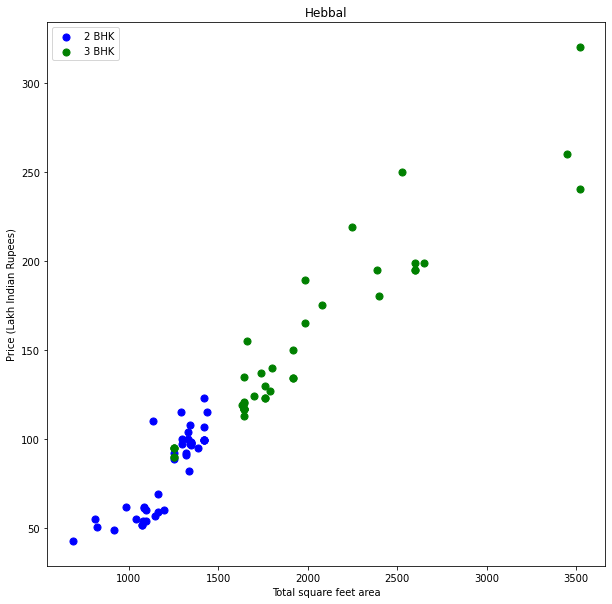

In [128]:
desturbution_per_location(data,"Hebbal")

Text(0, 0.5, 'count')

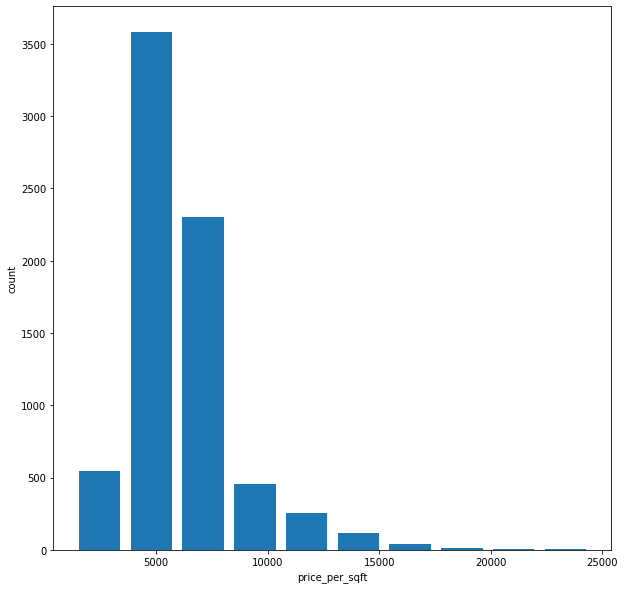

In [129]:
plt.figure(figsize=(10,10))
plt.hist(data.price_per_sqft,rwidth=0.8)
plt.xlabel('price_per_sqft')
plt.ylabel('count')


Text(0, 0.5, 'count')

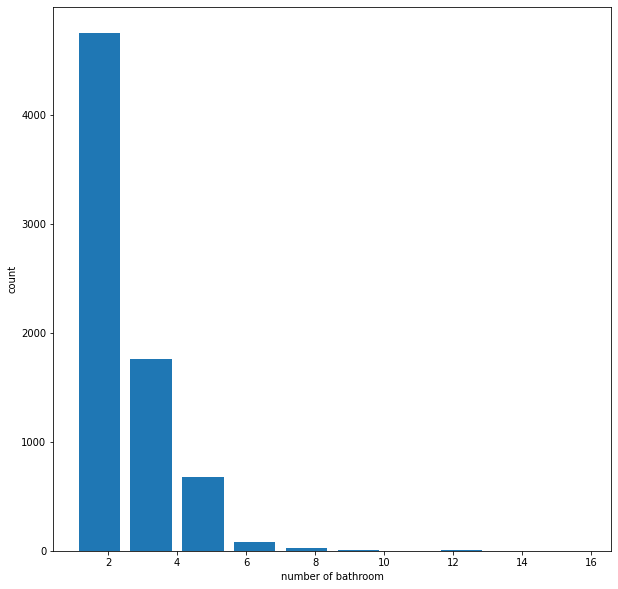

In [130]:
plt.figure(figsize=(10,10))
plt.hist(data.bath,rwidth=0.8)
plt.xlabel('number of bathroom')
plt.ylabel('count')

In [131]:
data=data[data.bath<data.Bedrooms+2]
data.drop(['price_per_sqft'],axis=1,inplace=True)

In [132]:
data_location=pd.get_dummies(data.location)
data.drop(['location'],axis=1,inplace=True)
data=pd.concat([data,data_location.drop(['other'],axis='columns')],axis='columns')
data.head()

,total_sqft,bath,price,Bedrooms,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Models benchmarking

1- linear Regression

In [133]:
X=data.drop(['price'],axis=1)
y=data['price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
linear_regression_=LinearRegression()
linear_regression_.fit(X_train,y_train)
print(linear_regression_.score(X_test,y_test))
print(linear_regression_.coef_.shape)
print(linear_regression_.intercept_)

0.8629132245229483
(243,)
-3.1324178525032664


2-Ridge

In [134]:
'''param_grid={'alpha':[0.001,0.01,0.1,10,50,100,200, 230, 250,265, 270, 275, 290, 300, 500]}
model_Ridge=GridSearchCV(Ridge(),param_grid,cv=cv)
model_Ridge.fit(X_train,y_train)'''
model_Ridge=Ridge(alpha=0.1)
'''print(model_Ridge.best_params_)
print(model_Ridge.best_score_)'''
model_Ridge.fit(X_train,y_train)
print(model_Ridge.coef_.shape)
print(model_Ridge.score(X_test,y_test))

(243,)
0.8627406615032278


3-Lasso

In [135]:
'''param_grid={'alpha':[0.0001,0.001,0.002,0.003,0.01,0.1,10,50,100,200, 230, 250,265, 270, 275, 290, 300, 500]}
model_Lasso=GridSearchCV(Lasso(),param_grid,cv=5)
model_Lasso.fit(X_train,y_train)'''
model_Lasso=Lasso(alpha=0.001)
'''print(model_Lasso.best_params_)
print(model_Lasso.best_score_)'''
model_Lasso.fit(X_train,y_train)
print(model_Lasso.coef_.shape)
print(model_Lasso.intercept_)
print(model_Lasso.score(X_test,y_test))

(243,)
-4.514889576899108
0.8628326799594133


Random forest

In [136]:
'''params_grid={
    'n_estimators':[50,150,200],
    'max_features':['sqrt', 'log2', 'None'],
    'min_samples_leaf':[1,5,10,15,20,30],
}
model_random_forest=GridSearchCV(RandomForestRegressor(),params_grid,cv=cv,n_jobs=-1)'''
model_random_forest=RandomForestRegressor(n_estimators=150,max_features='sqrt',min_samples_leaf= 1,random_state=45)
model_random_forest.fit(X_train,y_train)
'''print(model_random_forest.best_params_)
print(model_random_forest.best_score_)'''
print(model_random_forest.score(X_test,y_test))

0.8304671375945698


gradient Boost

In [137]:
'''param_grid={'n_estimators':range(80,150,10),'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200), 'min_samples_leaf':range(30,71,10),'max_features':range(7,20,2),'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],'learning_rate':[0.005,0.01,0.01,0.1]}
GradientBoosting_Regressor=GridSearchCV(GradientBoostingRegressor(random_state=0),param_grid,cv=5,n_jobs=-1)
GradientBoosting_Regressor.fit(X_train,y_train)
print(GradientBoosting_Regressor.best_score_)
print(GradientBoosting_Regressor.best_params_)
print(GradientBoosting_Regressor.score(X_test,y_test))'''

"param_grid={'n_estimators':range(80,150,10),'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200), 'min_samples_leaf':range(30,71,10),'max_features':range(7,20,2),'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],'learning_rate':[0.005,0.01,0.01,0.1]}\nGradientBoosting_Regressor=GridSearchCV(GradientBoostingRegressor(random_state=0),param_grid,cv=5,n_jobs=-1)\nGradientBoosting_Regressor.fit(X_train,y_train)\nprint(GradientBoosting_Regressor.best_score_)\nprint(GradientBoosting_Regressor.best_params_)\nprint(GradientBoosting_Regressor.score(X_test,y_test))"

In [ ]:
'''reg_xgb=xgb.XGBRegressor(objective='reg:linear',seed=123)
reg_xgb.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_set=[(X_test,y_test)])
reg_xgb.score(X_test,y_test)'''
'''train_dmatrix=xgb.DMatrix(data=X_train,label=y_train)
test_dmatrix=xgb.DMatrix(data=X_test,label=y_test)'''
params_grid={'max_depth':[3,4,5],
'learning_rate':[0.3,0.4,0.5,0.6,0.7],
'gamma':[0,0.1,0.2],
'reg_lambda':[0,0.1,0.2]}
Xgb_rg_opt=GridSearchCV(xgb.XGBRegressor(objective='reg:linear',seed=123,subsample=0.9,colsample_bytree=0.7),params_grid,verbose=0,
n_jobs=-1,cv=5)
Xgb_rg_opt.fit(X_train,y_train,early_stopping_rounds=10,verbose=0,eval_set=([(X_test,y_test)]))
print(Xgb_rg_opt.best_params_)



In [139]:
xgb_reg=xgb.XGBRegressor(objective='reg:linear',seed=123,subsample=0.9,colsample_bytree=0.7,gamma= 0, learning_rate= 0.5, max_depth= 4, reg_lambda=0)
xgb_reg.fit(X_train,y_train,early_stopping_rounds=10,verbose=True,eval_set=([(X_test,y_test)]))
print(xgb_reg.score(X_test,y_test))

[17:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.08197
[1]	validation_0-rmse:45.45319
[2]	validation_0-rmse:38.05083
[3]	validation_0-rmse:35.04813


c:\New folder\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:33.51137
[5]	validation_0-rmse:33.19739
[6]	validation_0-rmse:32.99600
[7]	validation_0-rmse:33.04614
[8]	validation_0-rmse:32.54534
[9]	validation_0-rmse:32.33791
[10]	validation_0-rmse:32.95671
[11]	validation_0-rmse:32.37586
[12]	validation_0-rmse:32.22793
[13]	validation_0-rmse:32.07711
[14]	validation_0-rmse:32.03050
[15]	validation_0-rmse:32.22441
[16]	validation_0-rmse:32.18294
[17]	validation_0-rmse:31.92937
[18]	validation_0-rmse:31.54944
[19]	validation_0-rmse:31.51751
[20]	validation_0-rmse:31.39242
[21]	validation_0-rmse:31.07662
[22]	validation_0-rmse:31.08429
[23]	validation_0-rmse:31.00101
[24]	validation_0-rmse:30.80066
[25]	validation_0-rmse:30.75458
[26]	validation_0-rmse:30.71654
[27]	validation_0-rmse:30.64944
[28]	validation_0-rmse:30.74336
[29]	validation_0-rmse:30.62007
[30]	validation_0-rmse:30.63046
[31]	validation_0-rmse:30.53862
[32]	validation_0-rmse:30.82573
[33]	validation_0-rmse:30.79123
[34]	validation_0-rmse:30.89088
[35]	validatio

among all the models we can say that linear regrission gave us the best performance with a score of 0.8629132245229483
so its the model chosen to make predictions

In [141]:
print(X.columns)

Index(['total_sqft', 'bath', 'Bedrooms', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)


In [1]:
def predicte_price(location,sqft,bath,bhk):
    loc_index=np.where(X.columns==location)[0][0]
    x=np.zeros(len(X.columns))
    x[0]=sqft
    x[1]=bath
    x[2]=bhk
    if loc_index>=0:
        x[loc_index]=1  
    return   linear_regression_.predict([x])[0] 

In [143]:
predicte_price('Vishveshwarya Layout',1000,2,2)

c:\New folder\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


11.719120177636817

In [ ]:
import pickle
with open('banglore_home_price_model.pickle','wb') as f:
    pickle.dump(linear_regression_,f) 

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))